In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity


# Spotify Music Recommendation System
Content-Based Recommendation using Audio Features

Problem Statement - 

Music streaming platforms must recommend relevant songs to users based on content similarity.
The goal of this project is to build a content-based music recommendation system using
Spotify audio features and evaluate its effectiveness using both traditional and
recommendation-specific metrics.


In [105]:
high_df = pd.read_csv(r"C:\Users\talen\Downloads\SpotifyData\high_popularity_spotify_data.csv")
print(high_df.head())
print(high_df.shape)

   energy    tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  157.969         0.521            pop    -7.777     0.122    0.535   
1   0.507  104.978         0.747            pop   -10.171     0.117    0.438   
2   0.808  108.548         0.554            pop    -4.169     0.159    0.372   
3   0.910  112.966         0.670            pop    -4.070     0.304    0.786   
4   0.783  149.027         0.777            pop    -4.477     0.355    0.939   

            track_artist  time_signature  speechiness  ...  instrumentalness  \
0  Lady Gaga, Bruno Mars               3       0.0304  ...            0.0000   
1          Billie Eilish               4       0.0358  ...            0.0608   
2          Gracie Abrams               4       0.0368  ...            0.0000   
3      Sabrina Carpenter               4       0.0634  ...            0.0000   
4       ROSÉ, Bruno Mars               4       0.2600  ...            0.0000   

           track_album_id mode key dur

In [106]:
low_df = pd.read_csv(r"C:\Users\talen\Downloads\SpotifyData\low_popularity_spotify_data.csv")
print(low_df.head())
print(low_df.shape)

   time_signature  track_popularity  speechiness  danceability  playlist_name  \
0             4.0                23       0.0393         0.636  Rock Classics   
1             4.0                53       0.0317         0.572  Rock Classics   
2             4.0                55       0.0454         0.591  Rock Classics   
3             4.0                64       0.1010         0.443  Jazz Classics   
4             4.0                62       0.0298         0.685  Jazz Classics   

                       track_artist  duration_ms  energy playlist_genre  \
0      Creedence Clearwater Revival     138053.0   0.746           rock   
1                         Van Halen     241600.0   0.835           rock   
2                      Stevie Nicks     329413.0   0.804           rock   
3  Ella Fitzgerald, Louis Armstrong     185160.0   0.104           jazz   
4                    Galt MacDermot     205720.0   0.472           jazz   

  playlist_subgenre  ...          track_album_id             p

In [107]:
spotify_df = pd.concat([high_df, low_df], axis=0)
spotify_df.shape

(4831, 29)

In [108]:
spotify_df.duplicated().sum()

np.int64(43)

In [109]:
spotify_df = spotify_df.drop_duplicates(subset=['track_name', 'track_artist'])

In [110]:
spotify_df.columns

Index(['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness',
       'liveness', 'valence', 'track_artist', 'time_signature', 'speechiness',
       'track_popularity', 'track_href', 'uri', 'track_album_name',
       'playlist_name', 'analysis_url', 'track_id', 'track_name',
       'track_album_release_date', 'instrumentalness', 'track_album_id',
       'mode', 'key', 'duration_ms', 'acousticness', 'id', 'playlist_subgenre',
       'type', 'playlist_id'],
      dtype='object')

In [111]:
audio = ['danceability','energy','acousticness','instrumentalness','valence','speechiness','liveness','tempo','loudness','duration_ms'] 

if 'playlist_genre' not in spotify_df.columns: 
    raise KeyError("spotify_df must contain 'playlist_genre' column as the target.")

cols = [c for c in audio if c in spotify_df.columns]
if len(cols) == 0:
    raise KeyError("No audio features from the default list were found in spotify_df.")

spotify_df.isna().sum()[cols]

danceability        1
energy              1
acousticness        1
instrumentalness    1
valence             1
speechiness         1
liveness            1
tempo               1
loudness            1
duration_ms         1
dtype: int64

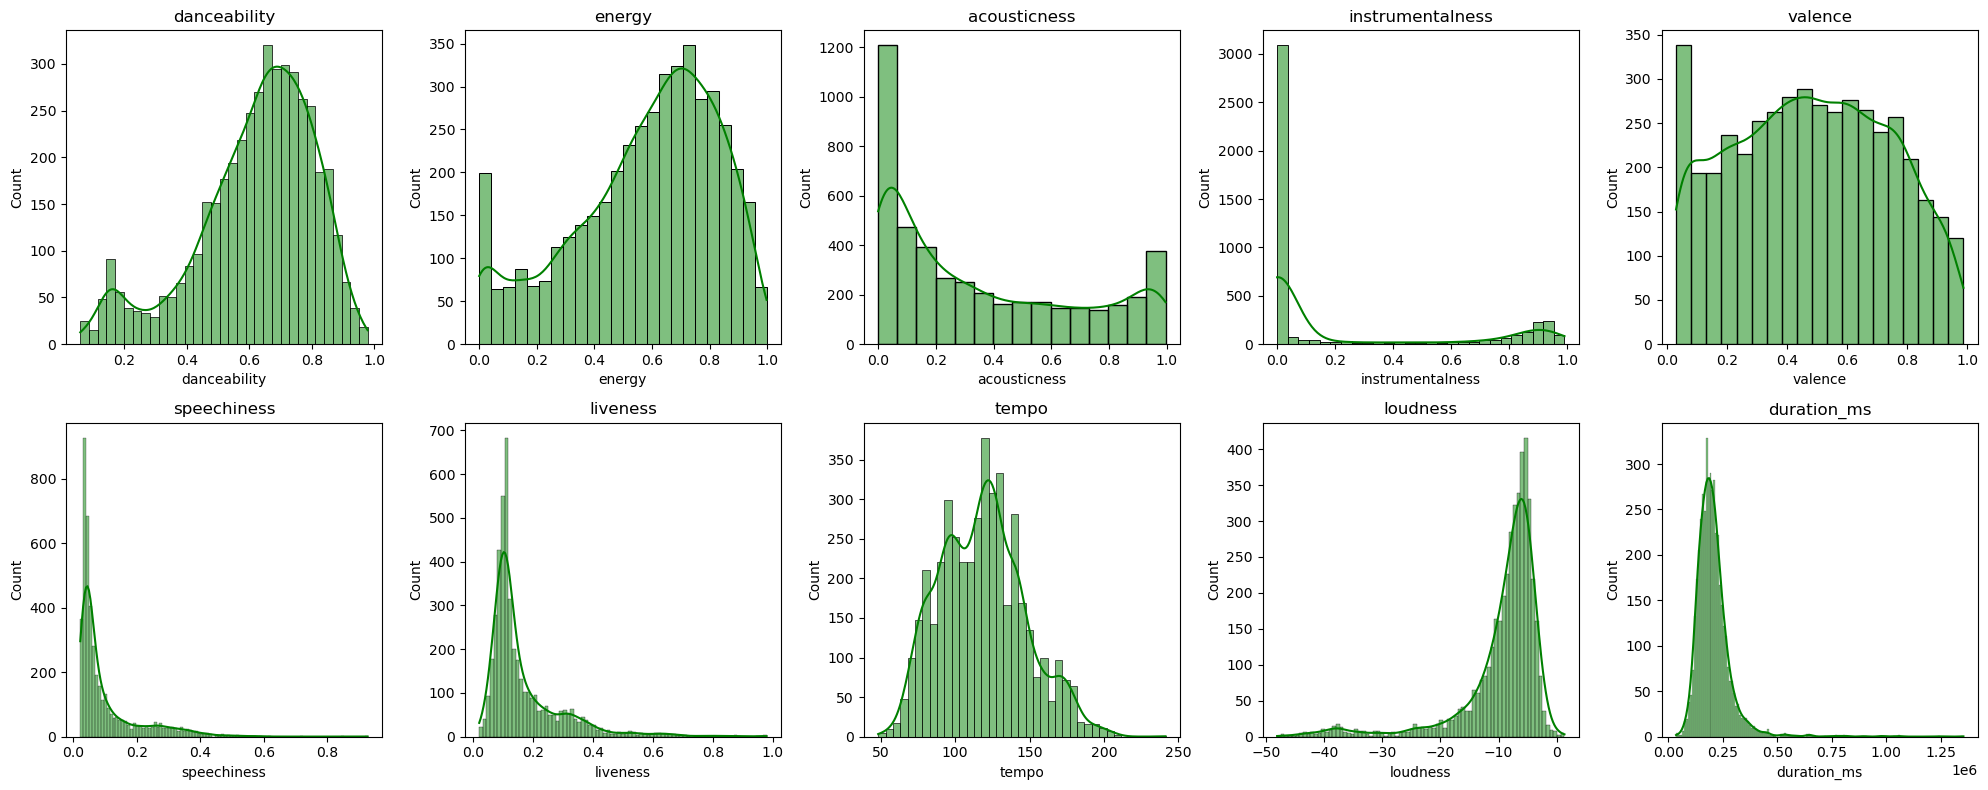

In [112]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for ax, col in zip(axes, cols):
    sns.histplot(spotify_df[col].dropna(), kde=True, ax=ax, color='green')
    ax.set_title(col)
plt.tight_layout()
plt.show()

##### Most audio features show strong skewness and non-Gaussian distributions (notably speechiness, instrumentalness, acousticness, and duration), validating the need for normalization and careful feature weighting in similarity and genre models.|

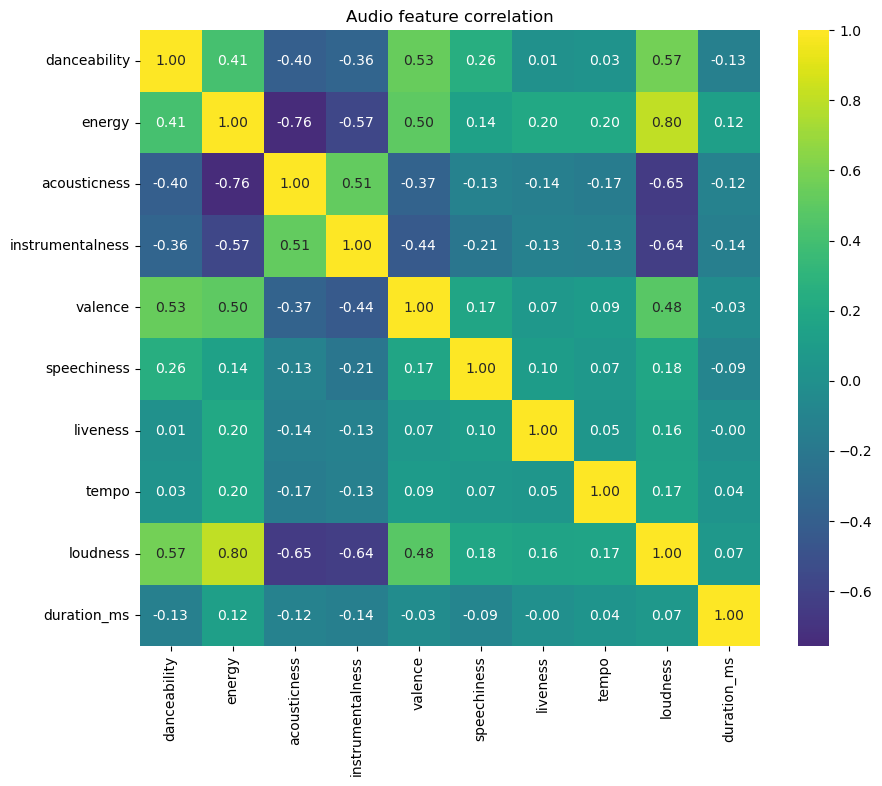

In [113]:
corr = spotify_df[cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', center=0)
plt.title("Audio feature correlation")
plt.show()

##### Correlation analysis revealed strong dependencies between energy, loudness, and acousticness, while tempo and duration provided largely independent signals, guiding effective feature selection for music similarity modeling.

In [114]:
X = spotify_df[cols].copy()
y = spotify_df['playlist_genre']

#missing values in columns
X = X.fillna(X.median())

# stratify to maintain genre proportions
stratify_arg = y if len(y.unique()) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_arg)


from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.05, max_depth=-1, class_weight="balanced", random_state=42)
lgbm.fit(X_train, y_train)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3572, number of used features: 10
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM] [Info] Start training from score -3.555348
[LightGBM]

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=400,
               random_state=42)

speechiness         31902
tempo               31073
duration_ms         31052
danceability        30264
valence             28984
energy              28869
acousticness        28839
loudness            28286
liveness            27518
instrumentalness    22546
dtype: int32


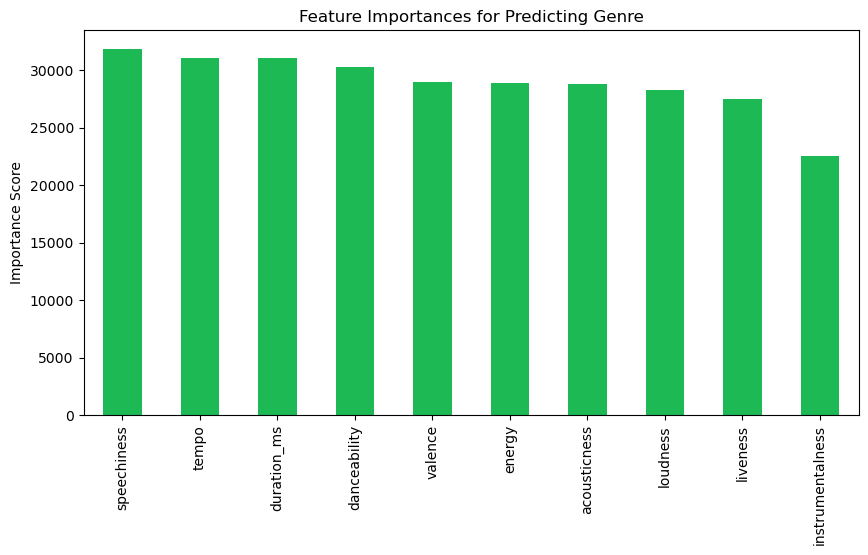

In [ ]:
lgbm_importance = pd.Series( lgbm.feature_importances_, index=X.columns ).sort_values(ascending=False)
print(lgbm_importance)
plt.figure(figsize=(10,5))
lgbm_importance.plot(kind='bar', color='#1DB954')
plt.title("Feature Importances for Predicting Genre")
plt.ylabel("Importance Score")
plt.show()

##### Genre prediction is driven primarily by speechiness, tempo and duration while instrumentalness, liveness and loudness influence it least.

In [116]:
y_pred = lgbm.predict(X_test)
report = classification_report(y_test,y_pred, zero_division=0, output_dict=True,)

for genre, value in report.items():
    print(f"{genre}: {value}")


afrobeats: {'precision': 0.5454545454545454, 'recall': 0.42857142857142855, 'f1-score': 0.48, 'support': 14.0}
ambient: {'precision': 0.4, 'recall': 0.3125, 'f1-score': 0.3508771929824561, 'support': 64.0}
arabic: {'precision': 0.43478260869565216, 'recall': 0.2702702702702703, 'f1-score': 0.3333333333333333, 'support': 37.0}
blues: {'precision': 0.45454545454545453, 'recall': 0.3125, 'f1-score': 0.37037037037037035, 'support': 16.0}
brazilian: {'precision': 0.5882352941176471, 'recall': 0.3448275862068966, 'f1-score': 0.43478260869565216, 'support': 29.0}
cantopop: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0}
classical: {'precision': 0.59375, 'recall': 0.8260869565217391, 'f1-score': 0.6909090909090909, 'support': 23.0}
country: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}
disco: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}
electronic: {'precision': 0.40268456375838924, 'recall': 0.5357142857142857, 'f1-score': 0.459770

In [117]:
importances = pd.Series(lgbm.feature_importances_, index=cols)
imp_order = importances.reindex(cols).fillna(0.0)  # ensure same order as cols

weights = imp_order / np.sqrt((imp_order**2).sum())
weights_dict = weights.to_dict()
print(weights_dict)

{'danceability': 0.32953627216937115, 'energy': 0.31434650546053317, 'acousticness': 0.3140198438108807, 'instrumentalness': 0.24549711843545605, 'valence': 0.31559870845086746, 'speechiness': 0.3473719982403938, 'liveness': 0.29963584250451875, 'tempo': 0.33834524798833165, 'loudness': 0.3079983807356209, 'duration_ms': 0.338116584833575}


In [118]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_scaled = num_pipeline.fit_transform(spotify_df[cols])
print("Scaled numeric shape:",num_scaled.shape) 

weight_vec = np.array([weights_dict.get(feat, 0.0) for feat in cols])
weighted_num = num_scaled * weight_vec[np.newaxis, :]  #np.newaxis adds a new dimension to an array.
print("Weighted numeric matrix shape:", weighted_num.shape)

Scaled numeric shape: (4466, 10)
Weighted numeric matrix shape: (4466, 10)


In [119]:
artists = spotify_df['track_artist'].fillna('unknown').astype(str).values.reshape(-1,1) #OneHotEncoder expects a 2D array

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

artists_ohe = ohe.fit_transform(artists)  # sparse matrix
print("Artist OHE shape (sparse):", artists_ohe.shape)


Artist OHE shape (sparse): (4466, 3390)


In [120]:
sim_num = cosine_similarity(weighted_num)
print("Numeric similarity matrix shape:", sim_num.shape)

sim_artist = cosine_similarity(artists_ohe)
print("Artist similarity matrix shape:", sim_artist.shape)

Numeric similarity matrix shape: (4466, 4466)
Artist similarity matrix shape: (4466, 4466)


In [121]:
def genre_overlap_rate(df, sim_matrix, k=10, genre_col='playlist_genre'):
    genres = df[genre_col].values
    n_local = len(df)
    rates = []
    for idx in range(n_local):
        sims = list(enumerate(sim_matrix[idx]))
        sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]  # skip self
        indices = [i for i,s in sims]
        rates.append((genres[indices] == genres[idx]).mean())
    return float(np.mean(rates))

base_overlap = genre_overlap_rate(spotify_df, sim_num, k=10)
print("Numeric-only genre overlap:", base_overlap)

Numeric-only genre overlap: 0.24626063591580838


##### only 25% of a song’s top-10 similar tracks share its genre, indicating that audio features alone capture some genre structure but are insufficient without contextual or categorical signals.

alpha=0.00 -> genre overlap = 0.1914
alpha=0.10 -> genre overlap = 0.3106
alpha=0.25 -> genre overlap = 0.3106
alpha=0.50 -> genre overlap = 0.3063
alpha=0.75 -> genre overlap = 0.2749
alpha=0.90 -> genre overlap = 0.2561
alpha=1.00 -> genre overlap = 0.2463
Best alpha: 0.1 (overlap = 0.3106)


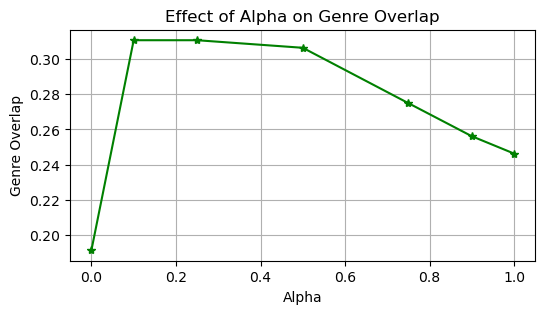

In [122]:
#coarse search
alphas = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0] #0.0 - audio only 
results = {}
for a in alphas:
    sim_mix = a * sim_num + (1 - a) * sim_artist
    overlap = genre_overlap_rate(spotify_df, sim_mix, k=10)
    results[a] = overlap
    print(f"alpha={a:.2f} -> genre overlap = {overlap:.4f}")

best_alpha = max(results, key=results.get)
print(f"Best alpha: {best_alpha} (overlap = {results[best_alpha]:.4f})")

#plot 
a_plot = list(results.keys())
overlaps_plot = list(results.values())

plt.figure(figsize=(6,3))
plt.plot(a_plot, overlaps_plot, marker='*', color='green')
plt.xlabel("Alpha")
plt.ylabel("Genre Overlap")
plt.title("Effect of Alpha on Genre Overlap")
plt.grid(True)
plt.show()


In [123]:
# fine search
fine_alphas = list(np.linspace(0, 1, 21))
fine_results = {}
for a in fine_alphas:
    sim_mix = a * sim_num + (1 - a) * sim_artist
    fine_results[a] = genre_overlap_rate(spotify_df, sim_mix, k=10)
best_alpha_fine = max(fine_results, key=fine_results.get)
print(f"Best alpha: {best_alpha_fine} (overlap = {fine_results[best_alpha_fine]:.4f})")


Best alpha: 0.05 (overlap = 0.3106)


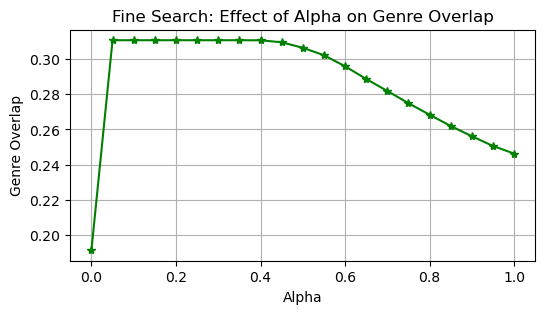

In [124]:
alphas_fine = sorted(fine_results.keys())
overlaps_fine = [fine_results[a] for a in alphas_fine]


plt.figure(figsize=(6,3))
plt.plot(alphas_fine, overlaps_fine, marker='*',color='green')
plt.xlabel("Alpha")
plt.ylabel("Genre Overlap")
plt.title("Fine Search: Effect of Alpha on Genre Overlap")
plt.grid(True)
plt.show()

##### In Coarse Search - Genre overlap improves sharply when a small amount of non-numeric information is introduced (α = 0.0 to 1.0), peaks around 0.31, and then degrades as similarity becomes dominated by that signal, showing the importance of balanced feature fusion.
##### In Fine Search -  Alpha value decreases during Fine Search indicating lower amount of non numeric information introduced producer higher result.

In [125]:
def recommend_song_by_name(song_name, df, sim_matrix, n=10, return_scores=True, title_col='track_name'):
    if song_name not in df[title_col].values:
        candidates = df[df[title_col].str.contains(song_name, case=False, na=False)][title_col].unique().tolist()
        raise KeyError(f"Song '{song_name}' not found. Did you mean one of: {candidates[:10]}")
    idx = int(df[df[title_col] == song_name].index[0])
    scores = list(enumerate(sim_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top = scores[1: n+1]
    indices = [i for i, s in top]
    results = df.iloc[indices].copy().reset_index(drop=True)
    if return_scores:
        results['similarity'] = [s for i,s in top]
    return results

In [ ]:
sim_best = best_alpha_fine * sim_num + (1 - best_alpha_fine) * sim_artist

example_title = "BIRDS OF A FEATHER"
print("Example query song:", example_title)
recs = recommend_song_by_name(example_title, spotify_df, sim_best, n=10)
display_cols = ['track_name', 'track_artist', 'playlist_genre', 'similarity'] if 'track_name' in spotify_df.columns else spotify_df.columns.tolist()
print(recs[display_cols].head(10))

Example query song: BIRDS OF A FEATHER
                  track_name                    track_artist playlist_genre  \
0               Male Fantasy                   Billie Eilish        ambient   
1                   The 30th                   Billie Eilish        ambient   
2         listen before i go                   Billie Eilish        ambient   
3             Halley's Comet                   Billie Eilish        ambient   
4                 WILDFLOWER                   Billie Eilish            pop   
5              Getting Older                   Billie Eilish        ambient   
6                       Rush                      Ayra Starr        ambient   
7                   Heathens               Twenty One Pilots           rock   
8  Tshwala Bam (feat. S.N.E)  TitoM, Yuppe, Burna Boy, S.N.E      afrobeats   
9                     Efecto                       Bad Bunny          latin   

   similarity  
0    0.964593  
1    0.954748  
2    0.947666  
3    0.946672  
4    0.9466

In [127]:
def random_baseline_overlap(df, k=10, genre_col='playlist_genre', n_trials=2000, seed=42):
    rng = np.random.default_rng(seed)
    genres = df[genre_col].values
    n_local = len(df)
    overlaps = []
    for _ in range(n_trials):
        idx = int(rng.integers(0, n_local))
        target_genre = genres[idx]
        others = rng.choice(np.delete(np.arange(n_local), idx), size=k, replace=False)
        overlaps.append((genres[others] == target_genre).mean())
    return float(np.mean(overlaps))

print("Random baseline overlap:", random_baseline_overlap(spotify_df, k=10, n_trials=2000))



Random baseline overlap: 0.06485


- almost 5× better than random.

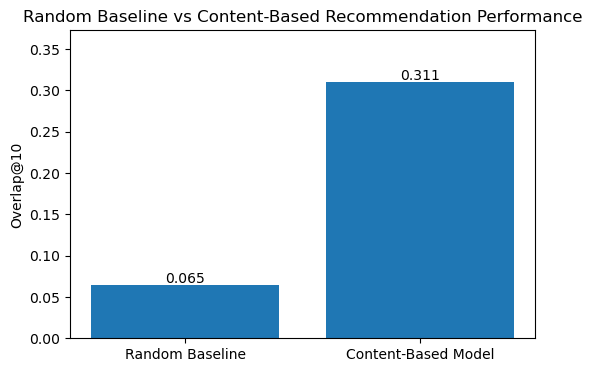

The model is -  4.790068092649647 - times better than random.


In [ ]:
# Replace these with your computed values
random_overlap = random_baseline_overlap(spotify_df, k=10, n_trials=2000)
model_overlap = fine_results[best_alpha_fine]

labels = ['Random Baseline', 'Content-Based Model']
values = [random_overlap, model_overlap]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.ylabel('Overlap@10')
plt.title('Random Baseline vs Content-Based Recommendation Performance')

# Annotate values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.002, f"{v:.3f}", ha='center')

plt.ylim(0, max(values) * 1.2)

plt.show()

improvement_times = model_overlap / random_overlap
print("The model is - ",improvement_times,"- times better than random.")

In [129]:
def per_genre_overlap(df, sim_matrix, k=10, genre_col='playlist_genre'):
    genres = df[genre_col].values
    n_local = len(df)
    results = defaultdict(list)
    for idx in range(n_local):
        sims = list(enumerate(sim_matrix[idx]))
        sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:k+1]
        indices = [i for i,s in sims]
        results[genres[idx]].append((genres[indices] == genres[idx]).mean())
    agg = {g: float(np.mean(v)) for g,v in results.items()}
    return pd.Series(agg).sort_values(ascending=False)

per_genre = per_genre_overlap(spotify_df, sim_best, k=10)
print("Per-genre overlap (best mix) - top 20:\n", per_genre.head(20))

Per-genre overlap (best mix) - top 20:
 lofi          0.711706
wellness      0.532500
classical     0.419828
punk          0.356522
hip-hop       0.348023
gospel        0.335294
electronic    0.328136
latin         0.327204
arabic        0.325543
rock          0.325081
afrobeats     0.298611
ambient       0.293730
cantopop      0.281481
pop           0.263146
brazilian     0.255782
r&b           0.254000
jazz          0.249655
world         0.236842
metal         0.203333
korean        0.200000
dtype: float64


In [130]:
# Remove non-genre rows
genre_metrics = class_report_df.drop(
    index=['accuracy', 'macro avg', 'weighted avg'],
    errors='ignore'
)[['precision', 'f1-score']]

genre_metrics.head()


,precision,f1-score
afrobeats,0.545455,0.480000
ambient,0.400000,0.350877
arabic,0.434783,0.333333
blues,0.454545,0.370370
brazilian,0.588235,0.434783


In [ ]:
analysis_df = genre_metrics.join( per_genre.rename('g_overlap'),how='inner')
analysis_df.head()

,precision,f1-score,g_overlap
afrobeats,0.545455,0.480000,0.298611
ambient,0.400000,0.350877,0.293730
arabic,0.434783,0.333333,0.325543
blues,0.454545,0.370370,0.180769
brazilian,0.588235,0.434783,0.255782


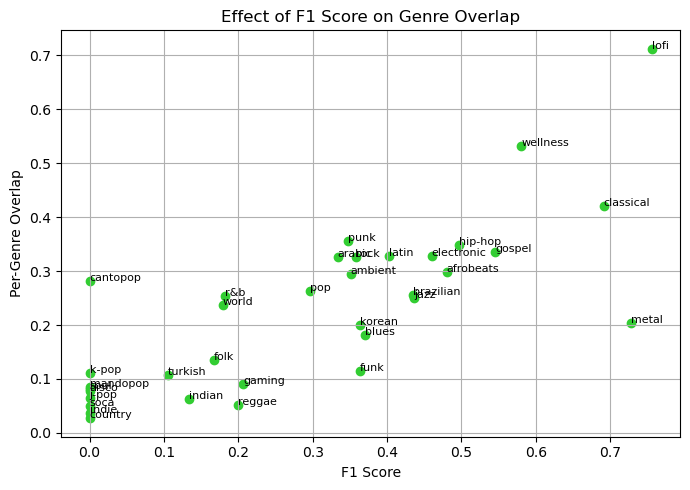

In [ ]:
plt.figure(figsize=(7, 5))

plt.scatter( analysis_df['f1-score'], analysis_df['g_overlap'], color="limegreen")

for genre in analysis_df.index:
    plt.annotate(
        genre,
        (analysis_df.loc[genre, 'f1-score'],
         analysis_df.loc[genre, 'g_overlap']),
        fontsize=8
    )
    
plt.xlabel('F1 Score')
plt.ylabel('Per-Genre Overlap')
plt.title('Effect of F1 Score on Genre Overlap')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Genres with higher classification F1 scores consistently show higher per-genre overlap, indicating that better genre separability directly translates into more genre consistent recommendations, with niche genres (e.g., lofi, wellness) benefiting the most.

## Conclusion

This project demonstrates how audio features can be effectively leveraged to build
a scalable content-based music recommendation system with meaningful evaluation.
